In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'construction-site-safety-image-dataset-roboflow:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2919095%2F5048288%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240308%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240308T081547Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6eaf39a1af6fb852d27465b247317bc97241bba9a62968779b100d670ff7161624ec06dbf3b173632714b59dce6f6f8077dd8f2236794c40f24f7d8aae7a0c0cfb5d6627ed65f7643d8820a0f277dd95c6ea4ce04f5cf9fa7d3c46f2fbb2d1c2954bf5df2958617062cb384e66516789e8c557103adb56448800d8de9dc0742298c9e66df651ac342d9e419d76a2eb572953448bb063791a507abf641535417cccda1d2c481398f065d239dfb50d62014a65f328ab2a2484260340eb208f417d27d00f7ef407a1795e82c4f064eb7edb04f06e7d9ede842bc6077adf2a36edfa3c8ee1b587543723b099563959ee4fd139fa16893323751ab66456ad2356d331'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 216024261 bytes downloaded
Downloaded and uncompressed: construction-site-safety-image-dataset-roboflow
Data source import complete.


In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.5/719.5 kB 11.2 MB/s eta 0:00:00


In [3]:
from warnings import filterwarnings
filterwarnings(action="ignore")
from ultralytics import YOLO

import os
import cv2
import yaml
import requests
import numpy as np
import pandas as pd
from tensorflow.keras.utils import img_to_array, load_img

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [4]:
path = "/kaggle/input/construction-site-safety-image-dataset-roboflow"
data = {"images":[], "labels":[], "split_type":[]}

for css_data in os.listdir(path):
    if css_data == "css-data":
        c_d = os.path.join(path, css_data)
        for split_type in os.listdir(c_d):
            if split_type in  ["train", "test", "valid"]:
                s_t = os.path.join(c_d, split_type)
                for names in os.listdir(s_t):
                    if names == "images":
                        root_dir = os.path.join(s_t, names)
                        for i in sorted(os.listdir(root_dir)):
                            data["images"].append(os.path.join(root_dir, i))
                            data["split_type"].append(split_type)
                    else:
                        root_dir = os.path.join(s_t, names)
                        for i in sorted(os.listdir(root_dir)):
                            data["labels"].append(os.path.join(root_dir, i))

df = pd.DataFrame(data)

print(df.shape)

df.head()

(2801, 3)


,images,labels,split_type
0,/kaggle/input/construction-site-safety-image-d...,/kaggle/input/construction-site-safety-image-d...,valid
1,/kaggle/input/construction-site-safety-image-d...,/kaggle/input/construction-site-safety-image-d...,valid
2,/kaggle/input/construction-site-safety-image-d...,/kaggle/input/construction-site-safety-image-d...,valid
3,/kaggle/input/construction-site-safety-image-d...,/kaggle/input/construction-site-safety-image-d...,valid
4,/kaggle/input/construction-site-safety-image-d...,/kaggle/input/construction-site-safety-image-d...,valid


## EDA

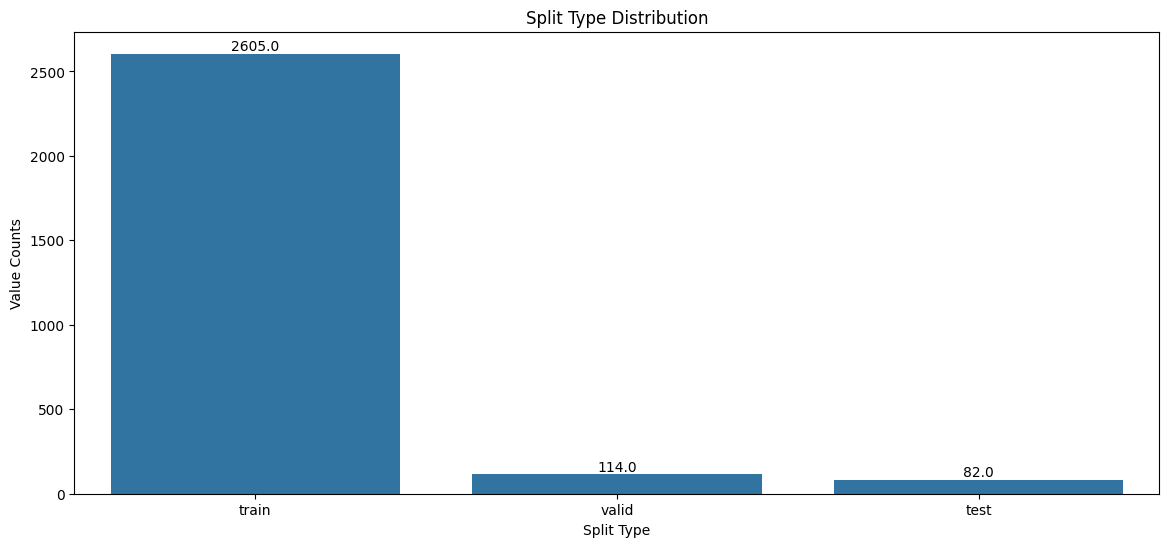

In [5]:
split_dist = df["split_type"].value_counts()

plt.figure(figsize=(14, 6))
barplot = sns.barplot(x=split_dist.index, y=split_dist.values)
for p in barplot.patches:
    h = p.get_height()
    barplot.text(p.get_x()+(p.get_width()/2), h, h, va="bottom", ha="center")

barplot.set_xlabel("Split Type")
barplot.set_ylabel("Value Counts")
barplot.set_title("Split Type Distribution")
plt.show()

In [6]:
for idx, labels in enumerate(df["labels"]):
    annotation = np.loadtxt(labels)
    if len(annotation) == 0:
        df.loc[idx, "is_annotated"] = False
    elif len(annotation) == 1:
        df.loc[idx, "is_annotated"] = True
    else:
        df.loc[idx, "is_annotated"] = True

In [7]:
df.drop(index=df[df["is_annotated"] == False].index, inplace=True)

In [8]:
df = df.reset_index(drop=True)

df.drop("is_annotated", axis=1, inplace=True)

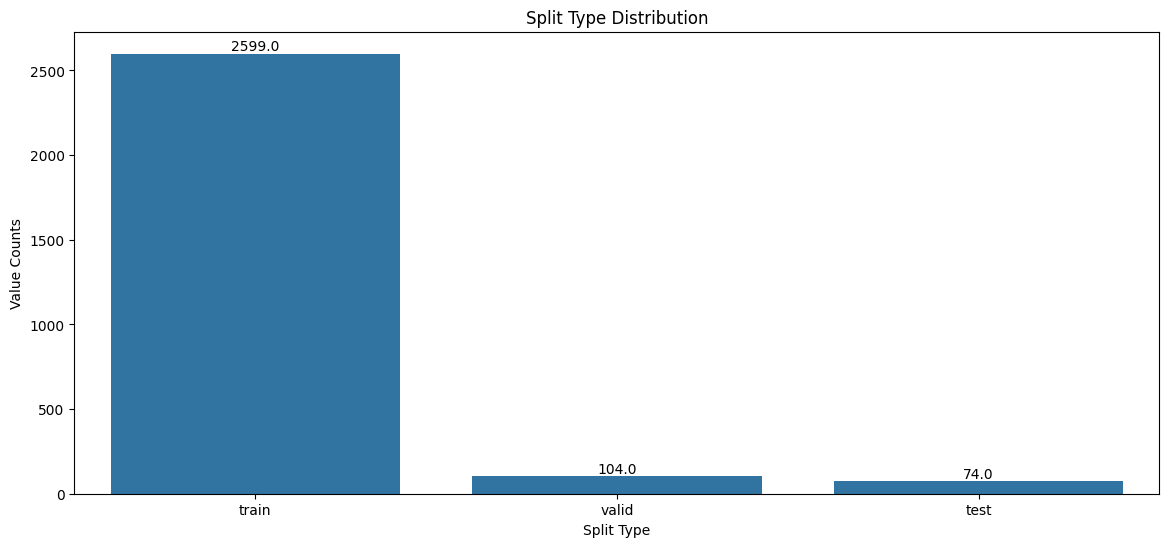

In [9]:
split_dist = df["split_type"].value_counts()

plt.figure(figsize=(14, 6))
barplot = sns.barplot(x=split_dist.index, y=split_dist.values)
for p in barplot.patches:
    h = p.get_height()
    barplot.text(p.get_x()+(p.get_width()/2), h, h, va="bottom", ha="center")

barplot.set_xlabel("Split Type")
barplot.set_ylabel("Value Counts")
barplot.set_title("Split Type Distribution")
plt.show()

In [10]:
class_names = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']
class_indices = dict(zip(range(len(class_names)), class_names))

print(class_indices)

{0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'}


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
os.makedirs(r"/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/train/images", exist_ok=True)
os.makedirs(r"/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/train/labels", exist_ok=True)
os.makedirs(r"/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/test/images", exist_ok=True)
os.makedirs(r"/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/test/labels", exist_ok=True)
os.makedirs(r"/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/valid/images", exist_ok=True)
os.makedirs(r"/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/valid/labels", exist_ok=True)


In [14]:
train = df[df["split_type"] == "train"]
test = df[df["split_type"] == "test"]
valid = df[df["split_type"] == "valid"]

for i in [train, test, valid]:
    i.drop("split_type", axis=1, inplace=True)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
valid = valid.reset_index(drop=True)

In [15]:
from shutil import copy

for img, lab in zip(train["images"], train["labels"]):
    copy(src=img, dst=os.path.join(r"/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/train/images", img.split("/")[-1]))
    copy(src=lab, dst=os.path.join(r"/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/train/labels", lab.split("/")[-1]))

for img, lab in zip(test["images"], test["labels"]):
    copy(src=img, dst=os.path.join(r"/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/test/images", img.split("/")[-1]))
    copy(src=lab, dst=os.path.join(r"/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/test/labels", lab.split("/")[-1]))

for img, lab in zip(valid["images"], valid["labels"]):
    copy(src=img, dst=os.path.join(r"/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/valid/images", img.split("/")[-1]))
    copy(src=lab, dst=os.path.join(r"/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/valid/labels", lab.split("/")[-1]))

## MODELLING

In [16]:
data = {"names": ["Hardhat", "Mask", "NO-Hardhat", "NO-Mask", "NO-Safety Vest", "Person", "Safety Cone", "Safety Vest", "machinery", "vehicle"],
        "nc": 10,
        "test": "/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/test",
        "train": "/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/train",
        "val": "/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/valid"}


with open("/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/data.yaml", "w+") as file:
     yaml.dump(data, file, default_flow_style = True)

In [23]:
pre_trained_model = YOLO("yolov8n.yaml").load('yolov8n.pt')

Transferred 355/355 items from pretrained weights


In [26]:
results = pre_trained_model.train(data='/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/data.yaml',
                                  epochs=30,
                                  imgsz = 416,
                                  batch = 32,
                                 # lr=0.0001,
                                  dropout= 0.5,
                                  device = 0)

Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/data.yaml, epochs=30, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train52, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.5, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=

train: Scanning /content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/train/labels.cache... 2599 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2599/2599 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Projects/Data science projects/Driver-Monitoring-System/valid/labels.cache... 104 images, 0 backgrounds, 0 corrupt: 100%|██████████| 104/104 [00:00<?, ?it/s]


Plotting labels to runs/detect/train52/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train52
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      6.07G      0.924      0.764      1.092         72        416: 100%|██████████| 82/82 [00:54<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all        104        697       0.82      0.631      0.694      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       5.8G     0.9989     0.8383      1.126         93        416: 100%|██████████| 82/82 [00:48<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        104        697       0.76      0.591      0.656      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      5.86G      1.035     0.8929      1.147        105        416: 100%|██████████| 82/82 [00:47<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all        104        697      0.724      0.615      0.641      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      5.85G      1.069      0.954      1.176         98        416: 100%|██████████| 82/82 [00:47<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all        104        697      0.791      0.574      0.629      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.84G       1.07     0.9368      1.173         55        416: 100%|██████████| 82/82 [00:51<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        104        697      0.793      0.554      0.628      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      5.93G       1.06     0.9356      1.167        115        416: 100%|██████████| 82/82 [00:49<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        104        697      0.784      0.565      0.645      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      5.91G      1.048      0.905      1.159         75        416: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all        104        697      0.769      0.586      0.636      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.95G      1.033     0.8839      1.141         74        416: 100%|██████████| 82/82 [00:54<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all        104        697      0.748      0.617      0.675      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      5.95G      1.034      0.877      1.149         75        416: 100%|██████████| 82/82 [00:50<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all        104        697      0.794      0.601       0.67       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      5.92G      1.005      0.849      1.133         59        416: 100%|██████████| 82/82 [00:49<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all        104        697      0.774      0.606      0.663      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      5.89G      1.008     0.8416      1.134         89        416: 100%|██████████| 82/82 [00:51<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all        104        697      0.802        0.6       0.67      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30       5.9G     0.9937     0.8184      1.128        101        416: 100%|██████████| 82/82 [00:52<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all        104        697      0.859      0.614      0.696      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.92G     0.9803     0.8039      1.118        113        416: 100%|██████████| 82/82 [00:52<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        104        697      0.818      0.596      0.678      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.88G     0.9773      0.796       1.12         78        416: 100%|██████████| 82/82 [00:51<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        104        697      0.826      0.612      0.694      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.83G     0.9567     0.7759      1.106         50        416: 100%|██████████| 82/82 [00:52<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all        104        697      0.834      0.635      0.714      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.91G      0.947       0.76      1.093         51        416: 100%|██████████| 82/82 [00:51<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        104        697      0.793      0.654      0.711      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.95G     0.9398      0.749      1.097         68        416: 100%|██████████| 82/82 [00:50<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all        104        697      0.839      0.638      0.707      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.94G     0.9339      0.737       1.09        136        416: 100%|██████████| 82/82 [00:51<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all        104        697      0.857      0.632      0.721      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.95G     0.9161      0.719      1.078         59        416: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        104        697        0.8      0.649      0.709      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.82G     0.9071     0.7103      1.074         67        416: 100%|██████████| 82/82 [00:51<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all        104        697      0.809      0.659      0.714      0.375


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.96G     0.8932      0.694       1.07         79        416: 100%|██████████| 82/82 [00:58<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

                   all        104        697      0.837      0.642      0.721      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.85G     0.8902     0.6807      1.062         97        416: 100%|██████████| 82/82 [00:49<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all        104        697      0.848       0.65       0.72       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.94G     0.8703     0.6617      1.059         99        416: 100%|██████████| 82/82 [00:48<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all        104        697      0.844      0.667      0.724       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.91G     0.8675     0.6602      1.053         96        416: 100%|██████████| 82/82 [00:48<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all        104        697      0.881      0.658      0.739      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.84G      0.856     0.6477      1.051        116        416: 100%|██████████| 82/82 [00:50<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all        104        697      0.868      0.655      0.742      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.94G     0.8441     0.6383      1.042         53        416: 100%|██████████| 82/82 [00:47<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        104        697      0.869      0.668       0.74      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.79G     0.8336      0.628       1.04         66        416: 100%|██████████| 82/82 [00:47<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all        104        697      0.795      0.702      0.745      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.95G     0.8243     0.6198      1.033         64        416: 100%|██████████| 82/82 [00:51<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        104        697      0.865      0.669      0.751      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.86G     0.8179     0.6115      1.029         80        416: 100%|██████████| 82/82 [00:49<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all        104        697      0.878      0.677      0.751      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.91G     0.8147     0.6119      1.029        100        416: 100%|██████████| 82/82 [00:47<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        104        697      0.825      0.709      0.749      0.451



30 epochs completed in 0.451 hours.
Optimizer stripped from runs/detect/train52/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train52/weights/best.pt, 6.2MB

Validating runs/detect/train52/weights/best.pt...
Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


                   all        104        697      0.826      0.708      0.749      0.452
               Hardhat        104         79      0.802      0.759      0.828      0.514
                  Mask        104         21      0.946      0.835      0.859      0.602
            NO-Hardhat        104         69       0.88      0.638      0.679       0.35
               NO-Mask        104         74      0.779      0.524        0.6      0.271
        NO-Safety Vest        104        106      0.866      0.689      0.715      0.416
                Person        104        166      0.747      0.735      0.796       0.49
           Safety Cone        104         44      0.905      0.862      0.878      0.497
           Safety Vest        104         41      0.922      0.756      0.825      0.509
             machinery        104         55        0.8      0.855      0.861      0.602
               vehicle        104         42      0.613      0.429      0.447      0.263
Speed: 0.1ms preproce